# Covid Count Model 1

Few keyboard shortcuts
- alt + enter (creates new code cell)
- esc + m (changes to markdown)
- esc + y (changes to code)
- ctrl + / (comment out multiple lines)

In [3]:
import pandas as pd                  # pd short for pandas
import numpy as np                   # np short for numpy
import seaborn 
import matplotlib.pyplot as plt     # plot short for matplotlib.pyplot
from matplotlib import style
style.use('ggplot')

In [4]:
import pathlib

# environment variables
working_directory = pathlib.Path.cwd()
data_directory = working_directory / "Data"
us_covid_data_name = "usa_covid_cases.csv"

In [5]:
# read in the data
usa_rona = pd.read_csv(data_directory/us_covid_data_name)

# get rid of the index column (optional)
usa_rona.reset_index(drop=True, inplace=True)

### Data Preview

In [6]:
print(usa_rona.shape) # dataframe dimensions (rows,columns)
print(usa_rona.head()) # view first 5 rows

(399, 59)
  iso_code      continent       location        date  total_cases  new_cases  \
0      USA  North America  United States  2020-01-22          1.0        NaN   
1      USA  North America  United States  2020-01-23          1.0        0.0   
2      USA  North America  United States  2020-01-24          2.0        1.0   
3      USA  North America  United States  2020-01-25          2.0        0.0   
4      USA  North America  United States  2020-01-26          5.0        3.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   gdp_per_capita  extreme_poverty  cardiovasc

In [7]:
# view column names
print(list(usa_rona.columns.values))

['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'new_vaccinations_smoothe

In [7]:
# Preprocessing Helpers

def filter_keep_column_subset(dataframe, list_columns):
    return dataframe[list_columns]

def count_nans_in_column(dataframe, column):
    # mask is a true/false series
    nan_mask = dataframe[column].isna()
    
    # counts the number of trues
    return nan_mask.sum()

def does_column_have_nans(dataframe, column):
    # mask is a true/false series
    nan_mask = dataframe[column].isna() 
    has_nan = nan_mask.any()
    return has_nan

def show_nan_metrics(dataframe):
    for column in dataframe.columns:
        has_nans = does_column_have_nans(dataframe, column)
        num_nans = count_nans_in_column(dataframe, column)
        print(f"{column}: {has_nans} {num_nans} NAs")

def nan_removal_process(raw_dataframe, columns_kept ,verbose = True):
    the_dataframe = raw_dataframe.copy()
    the_dataframe = filter_keep_column_subset(the_dataframe, columns_kept)
    
    if verbose:
        prompt_before_nans = "Data before Nans Dropped:" 
        print(prompt_before_nans)
        print(the_dataframe.head())
    
    print("","\n")
    print("Does the data have any Nans?")
    show_nan_metrics(the_dataframe)
    the_dataframe = the_dataframe.dropna()
    print("")
    print("Rows with Nans have been dropped")
    
    
    return the_dataframe

# def dataframe_equality(data1, data2):
#     return(data1 == data2).all()

In [8]:
columns_of_interest = ['date', 'new_cases']
final_covid_df = nan_removal_process(usa_rona, columns_of_interest)

Data before Nans Dropped:
         date  new_cases
0  2020-01-22        NaN
1  2020-01-23        0.0
2  2020-01-24        1.0
3  2020-01-25        0.0
4  2020-01-26        3.0
 

Does the data have any Nans?
date: False 0 NAs
new_cases: True 1 NAs

Rows with Nans have been dropped


In [9]:
final_covid_df

,date,new_cases
1,2020-01-23,0.0
2,2020-01-24,1.0
3,2020-01-25,0.0
4,2020-01-26,3.0
5,2020-01-27,0.0
...,...,...
394,2021-02-19,106355.0
395,2021-02-20,71510.0
396,2021-02-21,56495.0
397,2021-02-22,56044.0


### Exploratory Data Analysis

In [34]:
# exploratory data analysis helpers

def response_lineplot(dataframe, y, x = None, xlab = 'index', ylab = 'y', title ="Title", color = 'black', rotation = 0):
    if x == None:
        dataframe.plot(y = y, color = color)
        plt.xlabel(xlab) 
        plt.xticks(rotation = rotation)
        plt.ylabel(ylab)
        plt.title(title)
        plt.show()
    else:
        dataframe.plot(x = x, y = y, color = color)
        plt.xlabel(xlab)     
        plt.xticks(rotation = rotation)
        plt.ylabel(ylab)
        plt.title(title)
        plt.show()

def seaborn_den_hist_plot(dataframe, column, color = None, bins = None, only_hist = False, only_den = False, title = "",
                         rotation = 0):
    if only_hist == False and only_den == False:
        seaborn.distplot(dataframe[column], bins = bins, color = color, hist_kws={'edgecolor':'black'},
                         kde_kws={'linewidth': 2}).set(ylabel='Density', title = title)
        plt.xticks(rotation = rotation)
    if only_hist == True and only_den == False:
        seaborn.distplot(dataframe[column], kde = False, bins = bins, color = color,
                         hist_kws={'edgecolor':'black', 'linewidth':1.2} ).set(ylabel='Frequency', title = title)
        plt.xticks(rotation = rotation)
    if only_hist == False and only_den == True:
        seaborn.distplot(dataframe[column], hist = False, bins = bins, color = color,
                         kde_kws = {'shade': True, 'linewidth': 2, 'color': color} ).set(ylabel='Density', title = title)
        plt.xticks(rotation = rotation)

def necessary_response_plots(data, column_y, response_lineplot_title, den_hist_title, 
                            color, column_x = None, bins = None, rotation = None):
    if column_x == None:
        response_lineplot(data, y = column_y, ylab = column_y, title = response_lineplot_title, 
                          color = color, rotation = rotation)
    else:
        response_lineplot(data, y = column_y, x = column_x, 
                          xlab = column_x, ylab = column_y, title = response_lineplot_title,
                          color = color, rotation = rotation)
    
    seaborn_den_hist_plot(data, column_y, bins = bins, rotation = rotation, 
                      title = den_hist_title,
                      color = color)

#### Response Plots
The USA COVID-19 dataset is a daily new case count starting from 01-23-2020 through 02-23-2021. In the graph "New USA COVID-19 Cases Across Time" I see a initial increase of new COVID-19 cases on 03-13-2020 which was just around the time when the US government ordered a stay at home rule. New cases are still relatively high between 03-13-2020 and 09-29-2020. I can guess this maybe due to a number of factors such as front line workers getting exposed, getting exposed on outside trips to crowded areas, and not following CDC guidlines, etc. Starting from September 2020 until January 7th 2021, I see a shocking increase in new COVID-19 count cases. Its interesting to note that this occured during the heated political climate as well as the holiday season.   

In the second graph "Density and Historgram of New USA COVID-19 Cases", I can see it follows a possion distribution with a large fat right tail.

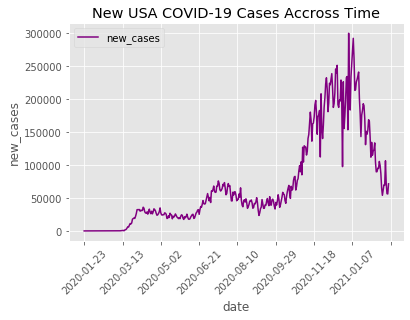

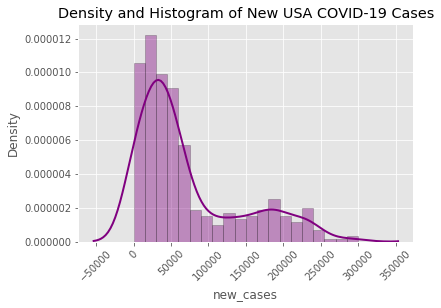

In [37]:
necessary_response_plots(final_covid_df, column_x = 'date', column_y = 'new_cases',
                         response_lineplot_title = "New USA COVID-19 Cases Accross Time",
                         den_hist_title = "Density and Histogram of New USA COVID-19 Cases",
                         color = 'purple', bins = 20, rotation = 45)

### Model 1 Specifications

We assume $y_i\sim\text{Pois}(\lambda_i)$ which corresponds to $y_i$ the observed count of new covid-19 cases where $\lambda_i$ is the unknown rate of catching new covid-19 cases. To complete the model we assume 
$$y_i\sim\text{Pois}(\lambda_i)\\
\lambda_i \sim\text{Ga}(\alpha,\theta)\\
\theta\sim\text{Ga}(a,b)$$
where $\alpha,a,b$ are fixed. The joint posterior distribution becomes

\begin{align*}
p(\lambda,\theta|y) &\propto\left[\prod_{i=1}^n \frac{\lambda_{i}^{y_i} \text{exp}\left\{-\lambda_i\right\}}{y_i!}
\frac{\lambda_{i}^{\alpha}}{\Gamma(\alpha)}\theta^{\alpha-1} \text{exp}\left\{-\theta\lambda_i\right\}  \right] \frac{\theta^a}{\Gamma(a)} b^{a-1} \text{exp}\left\{-b\theta\right\}\\
&\propto \left[\prod_{i=1}^n \lambda_{i}^{y_i} \text{exp}\left\{-\lambda_i\right\} \lambda_{i}^{\alpha} \theta^{\alpha-1}  \text{exp}\left\{-\theta\lambda_i\right\}\right] \theta^a \text{exp}\left\{-b\theta\right\}
\end{align*}

The distribution in brackets is going to follow a gamma distribution because the conjugate prior to a Poisson distribution is a Gamma Prior thus the conjugate posterior will follow a gamma distribution aswell. Thus the full conditionals are

\begin{align*}
(\lambda_i|\theta,y_i) &\propto \lambda_{i}^{y_i} \text{exp}\left\{-\lambda_i\right\} \lambda_{i}^{\alpha} \text{exp}\left\{-\theta\lambda_i\right\} \\
&\propto \lambda_{i}^{y_i + \alpha} \text{exp}\left\{-\lambda_i(\theta + 1)\right\} \\
&\sim \text{Ga}(y_i +\alpha,\, \theta + 1) \\
(\theta|\lambda_i,y_i) &\propto \left[\prod_{i=1}^n \theta^{\alpha-1}\text{exp}\left\{-\theta\lambda_i \right\}\right]\theta^a \text{exp}\left\{-b\theta\right\} \\
&\propto \theta^{\alpha n - n}\text{exp}\left\{-\theta \sum_{i=1}^{n} \lambda_i\right\}\theta^a \text{exp}\left\{-b\theta\right\} \\
&\propto \theta^{\alpha n - n + a}\text{exp}\left\{-\theta (b+\sum_{i=1}^{n} \lambda_i)\right\} \\
&\sim \text{Ga}\left(\alpha n +a - (n-1),\, b+\sum_{i=1}^{n} \lambda_i \right)
\end{align*}

### Define Gibbs Sampler

In [53]:
# Define a function for Gibbs Sampling
# N_mcmc: number of iters
def Gibbs(N_mcmc, yi, alpha, a, b): 
    n = len(yi)

    # initialize your samples
    lambda_i = np.zeros(shape=(N_mcmc,n))
    theta = np.zeros(shape=N_mcmc)
    
    lambda_i[0,:] = 1
    theta[0] = 1
    
    for i in range(1,N_mcmc):
        # iteratively update lambda_i and theta
        lambda_i[i,:] = np.random.gamma(shape= yi+alpha, scale= 1/(theta[i-1]+1), size= n)
        theta[i] = np.random.gamma(shape= alpha*n + a, scale= 1/(b + np.sum(lambda_i[i,:])), size= 1)        
    
    return(lambda_i, theta)

In [41]:
lambda_i,theta = Gibbs(N_mcmc=10000, yi = final_covid_df['new_cases'], alpha= 100, a=1, b=1 )

#### Remove the first 6000 rows 

In [45]:
# for numpy.delete(), axis= 0 implies row, 1 implies column
# obj: the row/column number 
posterior_lambda= np.delete(lambda_i, obj= range(6000), axis= 0)
posterior_theta= np.delete(theta, obj= range(6000) )

print("Dimensions of Posterior Lambda: ", posterior_lambda.shape)
print("Dimensions of Posterior Thetha: ", posterior_theta.shape)
print("Length of Posterior Lambda: ", len(posterior_lambda[:,1]))

Dimensions of Posterior Lambda:  (4000, 398)
Dimensions of Posterior Thetha:  (4000,)
Length of Posterior Lambda:  4000


In [43]:
print("Lamda_i Posterior Samples \n", posterior_lambda)
print("Theta Posterior Samples \n", posterior_theta)

Lamda_i Posterior Samples 
 [[   90.89998132   100.61567932    98.3723588  ... 56376.5814985
  56165.59327137 71627.76248837]
 [  103.23347654    96.0515623     90.93461169 ... 56118.02575067
  56043.08081701 71890.05042199]
 [  121.16408894    94.91767351    84.09531527 ... 56619.76120921
  56002.36924283 71172.58545021]
 ...
 [  106.88120152   102.76335683   108.14614554 ... 56707.07321467
  55899.76495661 71182.88493161]
 [   84.83312479    82.36813744   101.87189723 ... 56809.98870818
  56431.75352382 71587.18676685]
 [   97.83904391   105.68607885   102.28402242 ... 56699.93666461
  56406.24097362 71324.78651914]]
Theta Posterior Samples 
 [0.00140731 0.00140256 0.00141067 ... 0.0014158  0.00140976 0.00140342]


### Check For Parameter Convergence

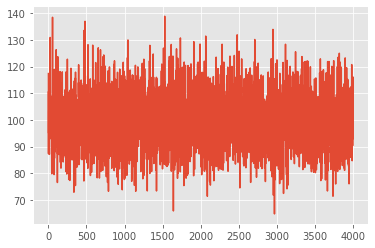

In [43]:
plt.plot(posterior_lambda[:,4])

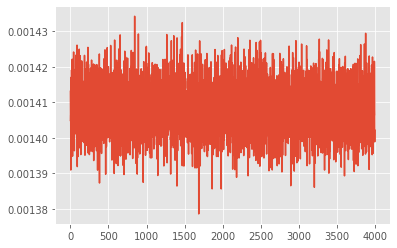

In [44]:
plt.plot(posterior_theta[:])

### Plotting the Full Posterior Conditionals

In [28]:
# with numpy.mean(), axis= 0 implies columns, 1 implies row 
avg_lambda= np.mean(posterior_lambda, axis=0)
avg_lambda.shape

(398,)

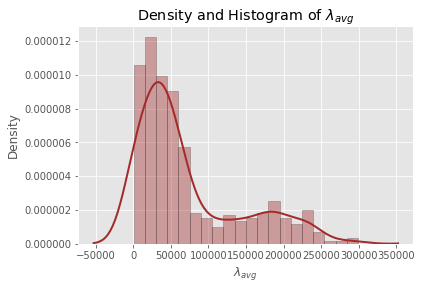

In [29]:
seaborn.distplot(avg_lambda, hist = True, kde = True, bins=20,
                color='brown', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}
                ).set(xlabel= '$\lambda_{avg}$', ylabel='Density',
                      title='Density and Histogram of $\lambda_{avg}$')
plt.show()

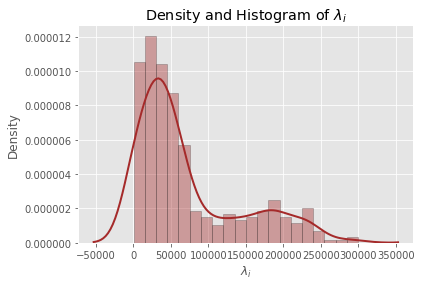

In [30]:
seaborn.distplot(posterior_lambda[3400,], hist = True, kde = True, bins=20,
                color='brown', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}
                ).set(xlabel= '$\lambda_{i}$', ylabel='Density',
                      title='Density and Histogram of $\lambda_{i}$')
plt.show()

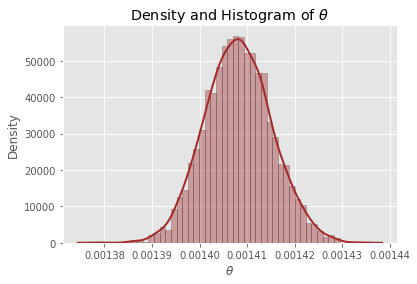

In [33]:
seaborn.distplot(posterior_theta, hist=True, kde=True, color='brown',
                hist_kws={'edgecolor': 'black'}, kde_kws={'linewidth':2}
                ).set(xlabel='$\u03B8$', title = 'Density and Histogram of $\u03B8$', ylabel='Density' )
plt.show()

## The Predictive Posterior Distribution
Let $\hat{y}_i$ denote the predictive posterior distribution. We wish to predict the outcome of new postitive covid-19 cases, $\hat{y}_i$. One simulates $\hat{y}_i$ by:
- simulating $(\lambda_i,\,\theta)$ from the joint posterior given $y_i$
- simulating $\hat{y}_i$ from its sampling density given the simulated values of $\lambda_i$ and $\theta$, $\hat{y}_i\sim\text{Pois}(\lambda_i)$

In [34]:
# Define a function for the posterior predictive
def poisson_posterior_predictive(lam_samps): 
    n = len(lam_samps[0,:])
    N_mcmc = len(lam_samps[:,0])
    
    posterior_predictive = np.zeros(shape=(N_mcmc,n))
    
    for i in range(N_mcmc):
        posterior_predictive[i,:] = np.random.poisson(lam = lam_samps[i,:], size = n)
    return(posterior_predictive)

In [35]:
# Simuate from the posterior predictive distribution
posterior_predictive = poisson_posterior_predictive(posterior_lambda)
print(posterior_predictive.shape)

(4000, 398)


### Posterior Predictive Check
Notice the model captures the prior information more than the observed data. So we would have to propose a better model that better captures the observed data

In [36]:
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(mean, color_mean, lw = .3)

In [38]:
quantile_posterior_predictive = np.quantile(posterior_predictive, [.025, .5, .97], axis=0)
print(quantile_posterior_predictive.shape)

(3, 398)


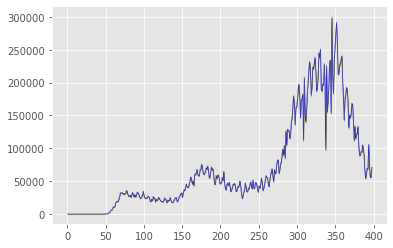

In [40]:
# zoomed between days 70 - 80 because its hard to see that damn shaded interval
mean = quantile_posterior_predictive[1,:]
lower = quantile_posterior_predictive[0,:]
upper = quantile_posterior_predictive[2,:]

plot_mean_and_CI(mean, upper,lower, color_mean='b', color_shading='k')

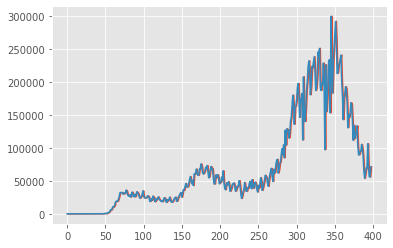

In [41]:
plt.plot(final_covid_df['new_cases'])
plt.plot(posterior_predictive.mean(0))

In [42]:
final_covid_df['new_cases'] - posterior_predictive.mean(0)

1      -99.87600
2      -99.75525
3     -100.28700
4      -99.97425
5      -99.88075
         ...    
394     52.17975
395      4.56450
396    -24.45750
397    -24.72325
398     -2.10075
Name: new_cases, Length: 398, dtype: float64